In [ ]:
#Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

%matplotlib inline


In [ ]:
#Load the Dataset

In [3]:
df = pd.read_csv("marketing_data.csv")
df.head()


,user_id,group,age,gender,device_type,traffic_source,region,time_on_site_sec,pages_visited,converted
0,1,pre,19,Male,Mobile,Email,East,421,11,0
1,2,post,23,Male,Mobile,Paid Ads,South,81,6,0
2,3,post,45,Female,Mobile,Organic,North,632,1,0
3,4,post,46,Male,Desktop,Organic,North,318,6,0
4,5,pre,43,Male,Mobile,Social Media,North,366,6,1


In [ ]:
#Basic Data Check

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           1500 non-null   int64 
 1   group             1500 non-null   object
 2   age               1500 non-null   int64 
 3   gender            1500 non-null   object
 4   device_type       1500 non-null   object
 5   traffic_source    1500 non-null   object
 6   region            1500 non-null   object
 7   time_on_site_sec  1500 non-null   int64 
 8   pages_visited     1500 non-null   int64 
 9   converted         1500 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 117.3+ KB


In [5]:
df.describe()


,user_id,age,time_on_site_sec,pages_visited,converted
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,750.500000,38.616667,469.680000,7.358000,0.102667
std,433.157015,11.995401,253.128208,4.077203,0.303624
min,1.000000,18.000000,30.000000,1.000000,0.000000
25%,375.750000,28.000000,245.750000,4.000000,0.000000
50%,750.500000,38.000000,465.000000,7.000000,0.000000
75%,1125.250000,49.000000,694.250000,11.000000,0.000000
max,1500.000000,59.000000,899.000000,14.000000,1.000000


In [ ]:
#Check Group Distribution

In [6]:
df["group"].value_counts()


group
post    759
pre     741
Name: count, dtype: int64

In [7]:
df["converted"].value_counts()


converted
0    1346
1     154
Name: count, dtype: int64

In [ ]:
#Split Pre and Post Campaign Groups

In [8]:
pre = df[df["group"] == "pre"]["converted"].values
post = df[df["group"] == "post"]["converted"].values

n_pre = len(pre)
n_post = len(post)

conv_pre = pre.sum()
conv_post = post.sum()

n_pre, conv_pre, n_post, conv_post


(741, 55, 759, 99)

In [ ]:
#Bayesian Model Definition

In [10]:
with pm.Model() as model:
    
    # Priors (conversion rates)
    theta_pre = pm.Beta("theta_pre", alpha=1, beta=1)
    theta_post = pm.Beta("theta_post", alpha=1, beta=1)
    
    # Likelihood
    y_pre = pm.Binomial("y_pre", n=n_pre, p=theta_pre, observed=conv_pre)
    y_post = pm.Binomial("y_post", n=n_post, p=theta_post, observed=conv_post)
    
    # Lift
    lift = pm.Deterministic("lift", theta_post - theta_pre)
    
    # Sampling
    trace = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_pre, theta_post]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


In [ ]:
#Trace Plot (Convergence Check)

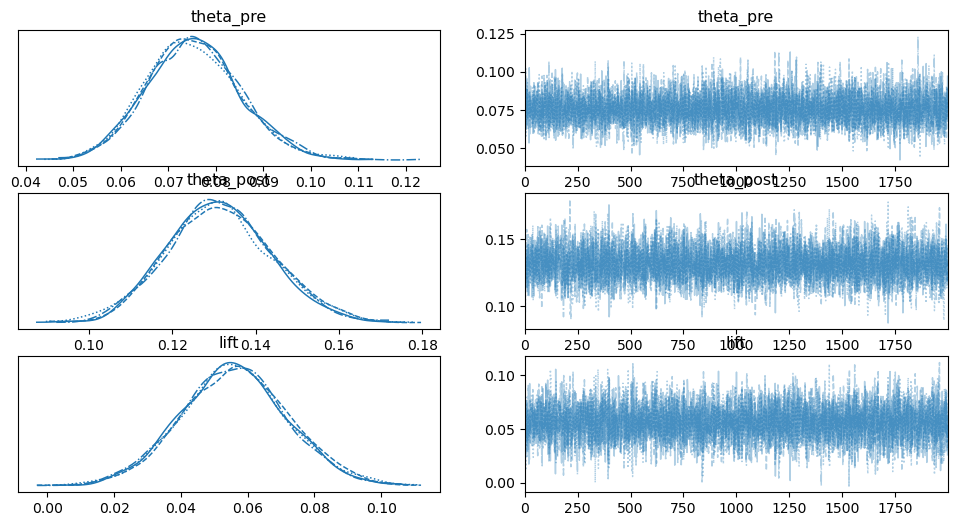

In [11]:
pm.plot_trace(trace)
plt.show()


In [ ]:
#Posterior Distributions (Conversion Rates)

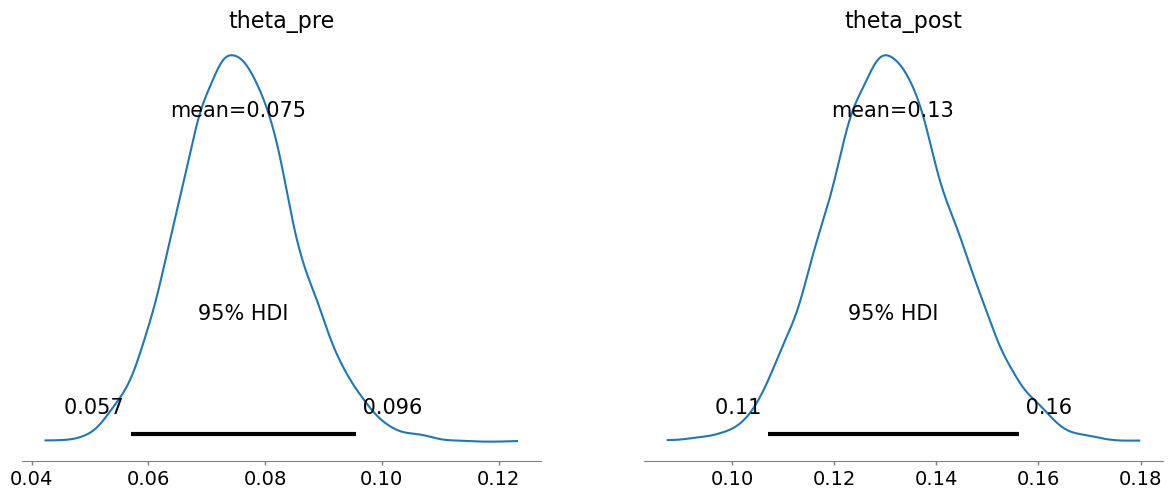

In [12]:
pm.plot_posterior(
    trace,
    var_names=["theta_pre", "theta_post"],
    hdi_prob=0.95
)
plt.show()


In [ ]:
#Posterior Distribution of Lift

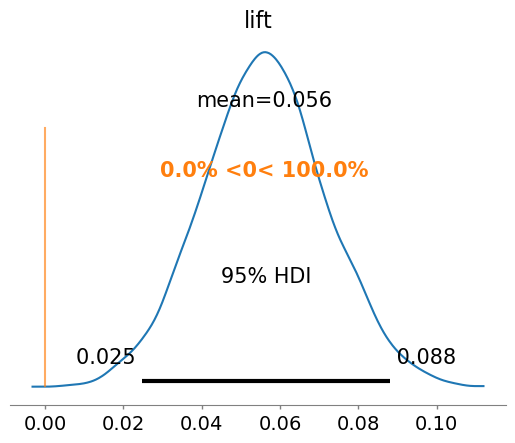

In [13]:
pm.plot_posterior(
    trace,
    var_names=["lift"],
    ref_val=0,
    hdi_prob=0.95
)
plt.show()


In [ ]:
#Posterior Summary (Credible Intervals)

In [14]:
pm.summary(trace, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_pre,0.075,0.010,0.057,0.096,0.0,0.0,6001.0,4176.0,1.0
theta_post,0.131,0.013,0.107,0.156,0.0,0.0,5391.0,4174.0,1.0
lift,0.056,0.016,0.025,0.088,0.0,0.0,4889.0,4688.0,1.0


In [ ]:
#Probability That Campaign Improved Conversions

In [15]:
lift_samples = trace.posterior["lift"].values.flatten()
prob_campaign_success = (lift_samples > 0).mean()

prob_campaign_success


0.99975

In [ ]:
#Frequentist Comparison

In [16]:
pre_rate = conv_pre / n_pre
post_rate = conv_post / n_post

pre_rate, post_rate, post_rate - pre_rate


(0.07422402159244265, 0.13043478260869565, 0.056210761016253)

In [ ]:
#Business Interpretation 

## Business Insights

- Post-campaign conversion rate is higher than pre-campaign
- Estimated lift is positive
- 95% credible interval excludes zero
- Probability of improvement is very high (>95%)

### Recommendation:
Continue or scale the marketing campaign.


## final conclusion

Bayesian A/B testing confirms that the marketing campaign led to a
statistically credible improvement in conversion rates.
The Bayesian approach allows direct probability-based decision making,
which is more intuitive and informative than traditional hypothesis testing.
